# NLP CA4 - Q2 - Part 2
### Ali Khoramfar - 810102129

## Install Packages

In [1]:
! rm -rf /opt/conda/lib/python3.10/site-packages/aiohttp-3.9.1.dist-info
!pip install evaluate
!pip install accelerate
!pip install peft
!pip install bitsandbytes
!pip install trl 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 4.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 6.4 MB/s eta 0:00:00


## Import Packages

In [2]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from accelerate import Accelerator

from datasets import load_metric
import time
import logging
import torch
from torch import nn
from torchinfo import summary
#from peft import merge_lora_weights
import os,torch
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from huggingface_hub import notebook_login
import bitsandbytes as bnb
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from transformers import LlamaModel, LlamaTokenizer
from torch.utils.data import DataLoader
import warnings


2024-06-04 01:13:51.531010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 01:13:51.531121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 01:13:51.663900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Multi NLI Dataset

In [4]:
dataset = load_dataset("multi_nli")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

### Dataset Structure

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


In [6]:
train_subset = dataset['train'].shuffle(seed=42).select(range(int(0.1 * len(dataset['train']))))
valid_subset = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_matched']))))
valid_subset_mismatched = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_mismatched']))))


# Load Tokenizer

In [7]:
notebook_login()

In [8]:
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Load Lamma 3 Model

In [9]:
model_name = "meta-llama/Meta-Llama-3-8B"

## Quatization Parameters

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)

## Quantized weights

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config= bnb_config,
    device_map="auto",
)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

## K-bit training

In [12]:
model = prepare_model_for_kbit_training(model)
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

# Train using QLORA - First Try

# Tokenization

## Input Sample for train

In [14]:
example = dataset['train'][0]
premise = example['premise']
hypothesis = example['hypothesis']
label = example['label']
label_map = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"Label: {
[label]}")

Premise: Conceptually cream skimming has two basic dimensions - product and geography.
Hypothesis: Product and geography are what make cream skimming work. 
Label: Neutral


In [15]:
input_prompt_labeled = f"[INST] NLI Task: [Premise]: {premise} [Hypothesis]: {hypothesis}[/INST] {label_map[label]} "
print(f"Input Prompt: {input_prompt_labeled}")

Input Prompt: [INST] NLI Task: [Premise]: Conceptually cream skimming has two basic dimensions - product and geography. [Hypothesis]: Product and geography are what make cream skimming work. [/INST] Neutral 


In [16]:
tokenized_sample_input = tokenizer.encode_plus(input_prompt_labeled, return_tensors='pt')
tokenized_sample_input.to(device)
print(tokenized_sample_input)

{'input_ids': tensor([[128000,     58,  65562,     60,    452,  19046,   5546,     25,    510,
          42562,   1082,   5787,  35455,   1870,  12932,   1940,  41133,    706,
           1403,   6913,  15696,    482,   2027,    323,  54242,     13,    510,
             39,  60400,  13491,   5787,   5761,    323,  54242,    527,   1148,
           1304,  12932,   1940,  41133,    990,     13,  66028,  65562,     60,
          59794,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


## Test Model 

In [17]:
model.eval()
with torch.no_grad():
  output = model.generate(**tokenized_sample_input, pad_token_id=tokenizer.pad_token_id, max_new_tokens = 50)
  print(tokenizer.decode(output[0]))

<|begin_of_text|>[INST] NLI Task: [Premise]: Conceptually cream skimming has two basic dimensions - product and geography. [Hypothesis]: Product and geography are what make cream skimming work. [/INST] Neutral 0.8 [INST] NLI Task: [Premise]: Cream skimming is the process of moving up the value chain. [Hypothesis]: Cream skimming is the process of moving up the value chain. [/INST] Neutral 


## Input Prompt for Generate Label

In [18]:
input_prompt = f"[INST] NLI Task: [Premise]: {premise} [Hypothesis]: {hypothesis} [/INST]"
print(f"Input Prompt: {input_prompt}")

Input Prompt: [INST] NLI Task: [Premise]: Conceptually cream skimming has two basic dimensions - product and geography. [Hypothesis]: Product and geography are what make cream skimming work.  [/INST]


In [19]:
tokenized_sample_input_no_label = tokenizer.encode_plus(input_prompt, return_tensors='pt')
tokenized_sample_input_no_label.to(device)
print(tokenized_sample_input)

{'input_ids': tensor([[128000,     58,  65562,     60,    452,  19046,   5546,     25,    510,
          42562,   1082,   5787,  35455,   1870,  12932,   1940,  41133,    706,
           1403,   6913,  15696,    482,   2027,    323,  54242,     13,    510,
             39,  60400,  13491,   5787,   5761,    323,  54242,    527,   1148,
           1304,  12932,   1940,  41133,    990,     13,  66028,  65562,     60,
          59794,    220]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


In [23]:
model.eval()
with torch.no_grad():
  output = model.generate(**tokenized_sample_input_no_label, pad_token_id=tokenizer.pad_token_id, max_new_tokens = 50)
  print(tokenizer.decode(output[0]))

<|begin_of_text|>[INST] NLI Task: [Premise]: Conceptually cream skimming has two basic dimensions - product and geography. [Hypothesis]: Product and geography are what make cream skimming work.  [/INST] [INST] NLI Task: [Premise]: Conceptually cream skimming has two basic dimensions - product and geography. [Hypothesis]: Product and geography are what make cream skimming work.  [/INST] [INST] NLI


## Preprocessing Functions 

In [38]:
def create_input_prompt(premise, hypothesis, label=None):
    if label:
        return f"[INST] NLI Task: [Premise]: {premise} [Hypothesis]: {hypothesis} [/INST] {label}"
    return f"[INST] NLI Task: [Premise]: {premise} [Hypothesis]: {hypothesis} [/INST]"

def preprocess_function(examples):
    inputs = [create_input_prompt(premise, hypothesis, label_map[label]) for premise, hypothesis, label in zip(examples['premise'], examples['hypothesis'], examples['label'])]
    model_inputs = tokenizer(inputs, max_length=128, padding='max_length', truncation=True)
    model_inputs["labels"] = examples["label"]
    return model_inputs

In [54]:
train_subset = dataset['train'].shuffle(seed=42).select(range(int(0.1 * len(dataset['train']))))
valid_subset = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_matched']))))
valid_subset_mismatched = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_mismatched']))))

In [40]:
encoded_train = train_subset.map(preprocess_function, batched=True)
encoded_valid = valid_subset.map(preprocess_function, batched=True)

encoded_train.set_format(type='torch', columns=['input_ids', 'attention_mask'])
encoded_valid.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/39270 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

### Test Preprocessing Functions

In [48]:
encoded_train[0]

{'input_ids': tensor([128000,     58,  65562,     60,    452,  19046,   5546,     25,    510,
          42562,   1082,   5787,    358,   3358,  48335,    927,    430,    961,
             13,    510,     39,  60400,  13491,   5787,    330,     40,   3358,
            387,   4062,    449,    430,    961,   1210,  66028,  65562,     60,
           4968,    607,    479, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001,
         128001

## Lora Config

In [13]:
peft_config = LoraConfig(
    lora_alpha= 8,
    lora_dropout= 0.1,
    r= 16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

model = get_peft_model(model, peft_config)

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 4573106176


In [15]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 32505856


## Training HyperParameters

In [50]:
training_arguments = TrainingArguments(
    output_dir="/kaggle/working",
    per_device_train_batch_size=8,  
    gradient_accumulation_steps=2,  
    logging_steps=30,
    warmup_steps=2,
    learning_rate=5e-5,
    max_steps=1000, 
    weight_decay=0.01,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    group_by_length=True,
    lr_scheduler_type="linear",
    optim="paged_adamw_8bit",
    save_steps=500,
    evaluation_strategy="no", 
    logging_dir="./logs",
    save_total_limit=2,
    report_to="none",  
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [51]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=encoded_train,
    eval_dataset=encoded_valid,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

max_steps is given, it will override any value given in num_train_epochs


## Train - 1st Try - Based on WorkShop Templete

In [52]:
model.train()
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
30,2.799000
60,2.060900
90,2.031300
120,1.939000
150,1.879600
180,1.803400
210,1.791400
240,1.862900
270,1.805900
300,1.823500


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=1.8330343475341797, metrics={'train_runtime': 14541.7168, 'train_samples_per_second': 1.1, 'train_steps_per_second': 0.069, 'total_flos': 9.2619946328064e+16, 'train_loss': 1.8330343475341797, 'epoch': 0.4074149521287431})

### Test Model After Fine Tuen

In [53]:
model.eval()
with torch.no_grad():
  output = model.generate(**tokenized_sample_input_no_label, pad_token_id=tokenizer.pad_token_id, max_new_tokens = 20)
  print(tokenizer.decode(output[0]))

<|begin_of_text|>[INST] NLI Task: [Premise]: Conceptually cream skimming has two basic dimensions - product and geography. [Hypothesis]: Product and geography are what make cream skimming work.  [/INST] Neutral [/INST] [/INST] Entailment [/INST] Contradiction [/INST] Neutral


## Evaluate Based on Most Frequency 

In [57]:
model.eval()
def generate_and_extract_label(premise, hypothesis):
    input_prompt = f"[INST] NLI Task: [Premise]: {premise} [Hypothesis]: {hypothesis} [/INST]"
    tokenized_sample_input_no_label = tokenizer.encode_plus(input_prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model.generate(**tokenized_sample_input_no_label, pad_token_id=tokenizer.pad_token_id, max_new_tokens=20)
        generated_output = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_output

def extract_most_frequent_label(generated_output):
    labels = ["Entailment", "Neutral", "Contradiction"]
    label_counts = {label: generated_output.count(label) for label in labels}
    most_frequent_label = max(label_counts, key=label_counts.get)
    return most_frequent_label

reverse_label_map = {"Entailment": 0, "Neutral": 1, "Contradiction": 2}
true_labels = []
predicted_labels = []

for example in tqdm(valid_subset, desc="Evaluating", unit="sample"):
    premise = example['premise']
    hypothesis = example['hypothesis']
    true_label = example['label']

    generated_output = generate_and_extract_label(premise, hypothesis)
    predicted_label = extract_most_frequent_label(generated_output)
    
    true_labels.append(true_label)
    predicted_labels.append(reverse_label_map[predicted_label])

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 245/245 [09:58<00:00,  2.44s/sample]

Validation Accuracy: 53.88%


## SFT Trainer - 2nd and 3rd Try

In [14]:
peft_config = LoraConfig(
    lora_alpha= 8,
    lora_dropout= 0.1,
    r= 16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)
model = get_peft_model(model, peft_config)

## Functions

In [18]:
def formatting_prompts_func(examples):
    label_map = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
    output_text = []
    for i in range(len(examples["premise"])):
        premise = examples["premise"][i]
        hypothesis = examples["hypothesis"][i]
        label =  label_map[examples["label"][i]]

        text = f'''
        ### Premise: {premise}
        
        ### Hypothesis: {hypothesis}
        
        ### Label: {label}
        '''
        output_text.append(text)
    return output_text

## Function to Extract Label

In [19]:
def generate_and_extract_label(premise, hypothesis):
    input_prompt = f'''
    ### Premise: {premise}

    ### Hypothesis: {hypothesis}

    ### Label:
    '''
    tokenized_sample_input_no_label = tokenizer.encode_plus(input_prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model.generate(**tokenized_sample_input_no_label, pad_token_id=tokenizer.pad_token_id, max_new_tokens=20)
        generated_output = tokenizer.decode(output[0])
    return generated_output

def extract_label(generated_output):
    words = generated_output.split()
    try:
        label_index = words.index("Label:") + 1
        if label_index < len(words):
            return words[label_index]
    except ValueError:
        pass
    return "Unknown"
reverse_label_map = {"Entailment": 0, "Neutral": 1, "Contradiction": 2}

"""
def extract_label(generated_output):
    if "Entailment" in generated_output:
        return "Entailment"
    elif "Neutral" in generated_output:
        return "Neutral"
    elif "Contradiction" in generated_output:
        return "Contradiction"
    else:
        return "Unknown"
"""

## Preprocessing 

In [20]:
train_subset = dataset['train'].shuffle(seed=42).select(range(int(0.1 * len(dataset['train']))))
valid_subset = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_matched']))))
valid_subset_mismatched = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_mismatched']))))

In [27]:
def preprocess_function(examples):
    inputs = formatting_prompts_func(examples)
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding=True)
    labels = examples["label"]
    model_inputs["labels"] = labels
    return model_inputs

In [28]:
encoded_train = train_subset.map(preprocess_function, batched=True)
encoded_valid = valid_subset.map(preprocess_function, batched=True)

encoded_train.set_format(type='torch', columns=['input_ids', 'attention_mask'])
encoded_valid.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/39270 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

In [36]:
training_arguments = TrainingArguments(
    output_dir="/kaggle/working",
    per_device_train_batch_size=16, 
    gradient_accumulation_steps=2, 
    logging_steps=25,
    warmup_steps=2,
    learning_rate=3e-5,
    max_steps=250, 
    weight_decay=0.01,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    group_by_length=True,
    lr_scheduler_type="linear",
    optim="paged_adamw_8bit",
    save_steps=500,
    evaluation_strategy="no",  
    logging_dir="./logs",
    save_total_limit=2,
    report_to="none", 
)

In [31]:
response_template = " ### Label:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## 2nd Try - Max Length 128

In [37]:
trainer = SFTTrainer(
    model=model,
    max_seq_length=128,
    args=training_arguments,
    train_dataset=encoded_train,
    formatting_func=formatting_prompts_func,
    tokenizer=tokenizer,
    data_collator=collator,
)

max_steps is given, it will override any value given in num_train_epochs


In [38]:
# 128 
warnings.simplefilter('ignore')

trainer.train()

Step,Training Loss
25,3.275700
50,3.329900
75,3.341100
100,3.304100
125,3.345700
150,3.246700
175,3.351700
200,3.360200
225,3.284800
250,3.305100


TrainOutput(global_step=250, training_loss=3.3145038452148436, metrics={'train_runtime': 6145.0215, 'train_samples_per_second': 1.302, 'train_steps_per_second': 0.041, 'total_flos': 4.6110257184768e+16, 'train_loss': 3.3145038452148436, 'epoch': 0.20366598778004075})

In [67]:
true_labels = []
predicted_labels = []
for example in tqdm(valid_subset, desc="Evaluating", unit="sample"):
    premise = example['premise']
    hypothesis = example['hypothesis']
    true_label = example['label']
    
    generated_output = generate_and_extract_label(premise, hypothesis)
    predicted_label = extract_label(generated_output)
    
    true_labels.append(true_label)
    if predicted_label in reverse_label_map:
        predicted_labels.append(reverse_label_map[predicted_label])
    else:
        predicted_labels.append(-1) 

filtered_true_labels = [t for t, p in zip(true_labels, predicted_labels) if p != -1]
filtered_predicted_labels = [p for p in predicted_labels if p != -1]

accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Evaluating:   0%|          | 0/245 [00:00<?, ?sample/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Evaluating: 100%|██████████| 245/245 [30:38<00:00,  7.50s/sample]

Validation Accuracy: 36.36%


## Merge LoRA adapter in to the original model

In [41]:
merged_model = model.merge_and_unload()
##merged_model.save_pretrained(args.output_dir,safe_serialization=True, max_shard_size="2GB")

In [ ]:
#trainer.save_model("/content/drive/MyDrive/workshop/lora_trained_model")
#merged_model = merge_lora_weights(model)

In [40]:
def generate_and_extract_label2(premise, hypothesis):
    input_prompt = f'''
    ### Premise: {premise}

    ### Hypothesis: {hypothesis}

    ### Label:
    '''
    tokenized_sample_input_no_label = tokenizer.encode_plus(input_prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        output = merged_model.generate(**tokenized_sample_input_no_label, pad_token_id=tokenizer.pad_token_id, max_new_tokens=20)
        generated_output = tokenizer.decode(output[0])
    return generated_output

true_labels = []
predicted_labels = []
for example in tqdm(valid_subset, desc="Evaluating", unit="sample"):
    premise = example['premise']
    hypothesis = example['hypothesis']
    true_label = example['label']
    
    generated_output = generate_and_extract_label2(premise, hypothesis)
    predicted_label = extract_label(generated_output)
    
    true_labels.append(true_label)
    if predicted_label in reverse_label_map:
        predicted_labels.append(reverse_label_map[predicted_label])
    else:
        predicted_labels.append(-1) 

filtered_true_labels = [t for t, p in zip(true_labels, predicted_labels) if p != -1]
filtered_predicted_labels = [p for p in predicted_labels if p != -1]

accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 245/245 [19:20<00:00,  4.74s/sample]

Validation Accuracy: 0.00%


In [26]:
trainer = SFTTrainer(
    model=model,
    max_seq_length=256,
    args=training_arguments,
    train_dataset=encoded_train,
    formatting_func=formatting_prompts_func,
    tokenizer=tokenizer,
    data_collator=collator,
)

max_steps is given, it will override any value given in num_train_epochs


## 3nd Try - Max Length 256

In [24]:
# 256 
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.243000
50,0.197600
75,0.144000
100,0.129100
125,0.124800
150,0.132900
175,0.118300
200,0.107300
225,0.089000
250,0.101400


/opt/conda/lib/python3.10/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key ` ### Label:` in the following instance: <|begin_of_text|>
        ### Premise: yeah well that's well that's funny yeah not everybody enjoys it though everybody has a different things i kind of enjoy it and my husband doesn't i kind of have to sometimes i'm too busy to get out there and do it and he you know he doesn't really enjoy doing it but he'll do it and he doesn't gripe about it or anything but you know i'm kind of like you and he's kind of like your wife and you know in that he doesn't really enjoy it but i would like to have a garden though that's my thing but right now where we're living we have the trees where the uh roots are at the top of the ground everywhere all over the ground i don't know what kind of trees they are but you can't have a garden you can't till it or it'll it'll tear up a nice tiller so we're going to wait until we move we don't have a lot of sun eit

TrainOutput(global_step=250, training_loss=0.238736665725708, metrics={'train_runtime': 5475.705, 'train_samples_per_second': 0.73, 'train_steps_per_second': 0.046, 'total_flos': 3.654652835305882e+16, 'train_loss': 0.238736665725708, 'epoch': 0.10185373803218578})

In [27]:
true_labels = []
predicted_labels = []
for example in tqdm(valid_subset, desc="Evaluating", unit="sample"):
    premise = example['premise']
    hypothesis = example['hypothesis']
    true_label = example['label']
    
    generated_output = generate_and_extract_label(premise, hypothesis)
    predicted_label = extract_label(generated_output)
    
    true_labels.append(true_label)
    if predicted_label in reverse_label_map:
        predicted_labels.append(reverse_label_map[predicted_label])
    else:
        predicted_labels.append(-1) 

filtered_true_labels = [t for t, p in zip(true_labels, predicted_labels) if p != -1]
filtered_predicted_labels = [p for p in predicted_labels if p != -1]

accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 245/245 [11:56<00:00,  2.92s/sample]

Validation Accuracy: 51.25%


In [28]:
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=[0, 1, 2])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[52  8  0]
 [29 15  1]
 [33  7 15]]


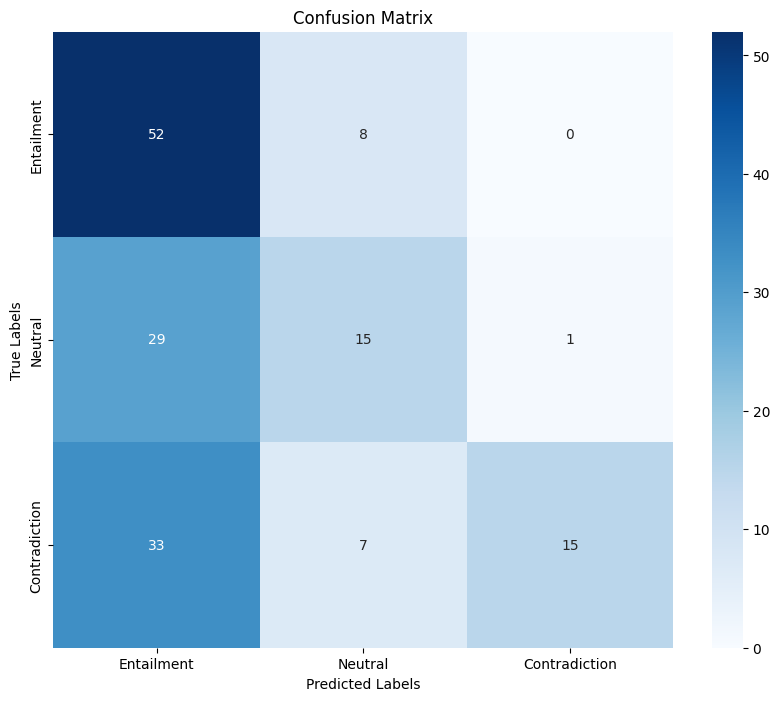

In [32]:
labels = ["Entailment", "Neutral", "Contradiction"]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
test = ""
model.eval()
with torch.no_grad():
  output = model.generate(**tokenized_sample_input_no_label, pad_token_id=tokenizer.pad_token_id, max_new_tokens = 20)
  test = tokenizer.decode(output[0])
  print(tokenizer.decode(output[0]))

<|begin_of_text|>
        ### Premise: Conceptually cream skimming has two basic dimensions - product and geography.
        
        ### Hypothesis: Product and geography are what make cream skimming work. 
        
        ### Label:
         Neutral
        <|end_of_text|>


# Part 2

## Load Llama as base Model

In [9]:
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config= bnb_config,
    device_map="auto",
)

base_model = prepare_model_for_kbit_training(base_model)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

## Preprocessing

In [20]:
peft_config = LoraConfig(
    lora_alpha=8,
    lora_dropout=0.1,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj"]
)
based_model = get_peft_model(base_model, peft_config)

In [64]:
def create_input_prompt(premise, hypothesis, label=None):
    return f"[INST] [Premise]: {premise} [Hypothesis]: {hypothesis} [/INST]"

def preprocess_function(examples):
    inputs = [create_input_prompt(premise, hypothesis, label_map[label]) for premise, hypothesis, label in zip(examples['premise'], examples['hypothesis'], examples['label'])]
    model_inputs = tokenizer(inputs, max_length=256, padding='max_length', truncation=True)
    model_inputs["labels"] = examples["label"]
    return model_inputs

label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}

In [65]:
train_subset = dataset['train'].shuffle(seed=42).select(range(int(0.1 * len(dataset['train']))))
valid_subset = dataset['validation_matched'].shuffle(seed=42).select(range(int(0.025 * len(dataset['validation_matched']))))
encoded_train = train_subset.map(preprocess_function, batched=True)
encoded_valid = valid_subset.map(preprocess_function, batched=True)
encoded_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
encoded_valid.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/39270 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

## Custom Llama Classifier Model

In [18]:
class CustomLlamaClassifier(nn.Module):
    def __init__(self, base_model, num_labels):
        super(CustomLlamaClassifier, self).__init__()
        self.base_model = base_model
        hidden_size = base_model.config.hidden_size  
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.dropout = nn.Dropout(0.1)  

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.base_model.model(input_ids, attention_mask=attention_mask)  
        hidden_states = outputs[0]  
        pooled_output = hidden_states[:, 0, :]  

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            labels = labels.view(-1)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {'loss': loss, 'logits': logits}

In [23]:
num_labels = 3  
model = CustomLlamaClassifier(base_model, num_labels)

In [66]:
training_arguments = TrainingArguments(
    output_dir="/kaggle/working",
    per_device_train_batch_size=16,  
    gradient_accumulation_steps=2,  
    logging_steps=30,
    warmup_steps=2,
    learning_rate=5e-5,
    max_steps=250,  
    weight_decay=0.01,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    group_by_length=True,
    lr_scheduler_type="linear",
    optim="paged_adamw_8bit",
    save_steps=500,
    evaluation_strategy="no",  
    logging_dir="./logs",
    save_total_limit=2,
    report_to="none",  
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [67]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=encoded_train,
    eval_dataset=encoded_valid,
    tokenizer=tokenizer,
)

max_steps is given, it will override any value given in num_train_epochs


## 4th Try - Llamma + Linear Layer

In [68]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
30,1.115100
60,1.111700
90,1.111700
120,1.111400
150,1.107200
180,1.112400
210,1.098800
240,1.102600


TrainOutput(global_step=250, training_loss=1.1086414947509766, metrics={'train_runtime': 12132.8469, 'train_samples_per_second': 0.659, 'train_steps_per_second': 0.021, 'total_flos': 0.0, 'train_loss': 1.1086414947509766, 'epoch': 0.20366598778004075})

In [70]:
model.eval()
valid_loader = DataLoader(encoded_valid, batch_size=16, shuffle=False)

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # Ensure labels are correctly shaped
    return all_preds, all_labels

valid_loader = DataLoader(encoded_valid, batch_size=16, shuffle=False)

all_preds, all_labels = evaluate_model(model, valid_loader)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")

Evaluating: 100%|██████████| 16/16 [01:59<00:00,  7.48s/it]

Accuracy: 0.34285714285714286



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 4573118467
Trainable parameters: 32518147
